# Track inner droplet with predictive cropping and HoughCircles

In this notebook, I implement the droplet tracking software using the following idea 
- crop the raw images so that inner droplet makes the majority of the cropped image
- use HoughCircles method to locate the droplet in the cropped image


The cropping in the next frame is determined based on the position detected on the previous frame. If droplet can be detected on every frame, this method should work perfectly. If there are some frames where droplet is missing (i.e. the return value of HoughCircles is None), we use the previous frame info to determine the crop. 

# Develop plan

- when saving cropped image, use the file names of raw images. Sometimes the tracking is not from the first image, and using an arbitrary counting system is not convenient.
- change the 't' column to 'file_name', for the same reason as above.
- when checking the tracking quality, load data from file, instead of use memory data.

In [138]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatch
from corrLib import readdata
from IPython.display import clear_output
import pandas as pd

## 1 Test idea

In [3]:
stack = io.imread('video-sample.tif')

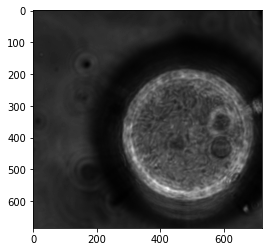

In [7]:
plt.imshow(stack[0], cmap='gray')

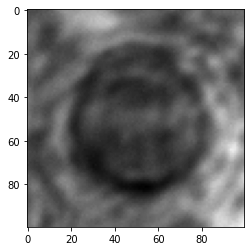

In [11]:
# we describe the crop by (upper, lower, left, right) tuple
crop = (380, 480, 540, 640)
cropped = stack[0][crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

In [18]:
# For this video, cropped image size (100, 100) is sufficient
circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, 1, 200, param2=1, maxRadius=40, minRadius=25)
circles

array([[[54.5, 49.5, 36. ]]], dtype=float32)

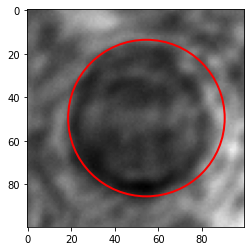

In [19]:
fig, ax = plt.subplots()
ax.imshow(cropped, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

In [26]:
# determine the crop of the next image
x0, y0 = 430, 590
crop_size = 50
if circles is not None:
    x, y = int(circles[0, 0, 0]+x0-crop_size), int(circles[0, 0, 1]+y0-crop_size)
    crop = [x - crop_size, x + crop_size, y - crop_size, y + crop_size]

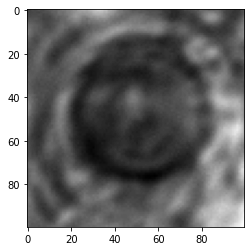

In [27]:
cropped = stack[1][crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

In [28]:
# detect circle in frame 2 (stack[1])
circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, 1, 200, param2=1, maxRadius=40, minRadius=25)
circles

array([[[53.5, 45.5, 33.8]]], dtype=float32)

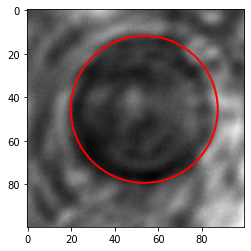

In [29]:
fig, ax = plt.subplots()
ax.imshow(cropped, cmap='gray')
for c in circles[0, :, :]:
    circle_object = mpatch.Circle((c[0], c[1]), c[2],
                                 fill=False, ec='red', lw=2)
    ax.add_patch(circle_object)

In [ ]:
# This loop can keep going 
# It breaks down when droplet cannot be detected for a long period
# in that case, either try take better video, or segment the video into pieces where droplet can be always detected

## 2 The testing loop

In [144]:
# Initial params
crop_anchor = np.array([380, 540]) # upper left corner coords
crop_size = (100, 100) # height and width
# HoughCircles params
Hough_dp = 1
Hough_minDist = max(crop_size)
Hough_param2 = 1
Hough_maxRadius = 40
Hough_minRadius = 25

# initialize result containers
x_list = []
y_list = []
t_list = []

stack = io.imread('video-sample.tif')
for t, img in enumerate(stack):    
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
    #     print(t, crop_anchor)   
    
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None:
        print(circles)
        x, y = int(circles[0, 0, 0]+crop_anchor[1]), int(circles[0, 0, 1]+crop_anchor[0])
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
    else:
        x, y = np.nan, np.nan
        
#     plt.imshow(cropped)
#     plt.plot(circles[0, 0, 0], circles[0, 0, 1], marker='o', color='red')
#     plt.pause(0.001)
    t_list.append(t)
    x_list.append(x)
    y_list.append(y)

[[[54.5 49.5 36. ]]]
[[[48.5 50.5 33.8]]]
[[[46.5 49.5 36.1]]]
[[[48.5 45.5 38.3]]]
[[[54.5 51.5 33.8]]]
[[[47.5 48.5 35.8]]]
[[[45.5 49.5 37.1]]]
[[[47.5 48.5 37.1]]]
[[[49.5 44.5 33.8]]]
[[[47.5 48.5 32.6]]]


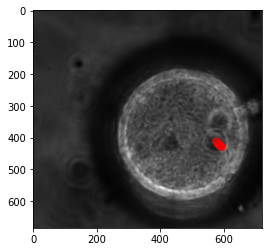

In [145]:
# draw the trajectory
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for x, y in zip(x_list, y_list):
    circle_object = mpatch.Circle((x, y), 10,
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)

**Comments:**
- the tracking works well for the 10 frame test
- need to develop tools that can promptly locate the frame where error occurs
    - save cropped images: if no droplet can be found there, that's where error occurs
    - save the length of HoughCircles results (circles): if too many circles are detected or no circle is detected for too long, there is a problem
- predict cropping region using velocity information
- the HoughCircles params can be adaptive

## 3 Large test

Test with real experimental image sequences. The images used for this test are not saved in the repository due to the large size. 

The code will generate a traj.csv file containing the trajectory data of inner droplet (x, y, t). For debuggin purpose, the code will also save some cropped images. The output folder architecture is 
```
|- main image folder
    other images ... (.tif)
    |- crop_houghCircles
        traj.csv
        |- cropped
            cropped images ... (.jpg)
```

In [214]:
%%time
folder = '/home/zhengyang/data/DE/07162021/3/'
l = readdata(folder, 'tif')

CPU times: user 19.7 ms, sys: 3.88 ms, total: 23.6 ms
Wall time: 21.5 ms


In [216]:
# Initial params
crop_anchor = np.array([180, 330]) # upper left corner coords, int
crop_size = (100, 100) # height and width, int
save_crop_step = 20 # save cropped image every save_crop_step steps, int
start_frame = 0
end_frame = None

# HoughCircles params
Hough_dp = 1
Hough_minDist = max(crop_size)
Hough_param2 = 1
Hough_maxRadius = 40
Hough_minRadius = 25

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame

# initialize output folder
main_output_folder = os.path.join(folder, 'crop_HoughCircles')
cropped_folder = os.path.join(folder, 'crop_HoughCircles', 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)
    
for num, i in l.iterrows():
    if num < start_frame:
        continue
    # read image
    img_raw = io.imread(i.Dir)
    # convert 16-bit to 8-bit
    if img_raw.dtype == 'uint16':
        img = (img_raw/2**8).astype('uint8')
    else:
        print(img_raw.dtype)
        break
    # set crop using crop_anchor and crop_size
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
    # use HoughCircles to detect circles in the cropped image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None: # check if any circle is detected
        x, y = circles[0, 0, 0]+crop_anchor[1], circles[0, 0, 1]+crop_anchor[0]
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        
        # update crop_anchor with the position of circle detected
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
    else:
        # if no circle is detected, set x, y to NaN
        x, y = np.nan, np.nan
    
    if num % save_crop_step == 0: # save cropped image and detecting result for validating purpose
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(cropped, cmap='gray')
        circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        plt.tight_layout()
        fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
        plt.close() # prevent figure from showing up inline
    
    # record information from each step in lists
    filename_list.append(i.Name)
    x_list.append(x)
    y_list.append(y)
    nc_list.append(len(circles))
    
    # check end_frame
    if end_frame is not None:
        if num >= end_frame-1:
            break

data = pd.DataFrame({'x':x_list, 'y':y_list, 'filename':filename_list, 'num_circle':nc_list})
data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)

In [217]:
data

,x,y,filename,num_circle
0,384.5,232.5,Image4_00001,1
1,384.5,230.5,Image4_00002,1
2,382.5,230.5,Image4_00003,1
3,379.5,226.5,Image4_00004,1
4,375.5,231.5,Image4_00005,1
...,...,...,...,...
1774,390.5,531.5,Image4_01775,1
1775,374.5,495.5,Image4_01776,1
1776,375.5,492.5,Image4_01777,1
1777,376.5,492.5,Image4_01778,1


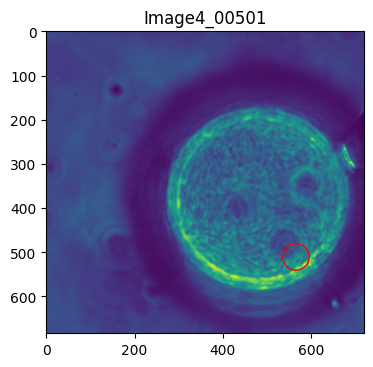

In [221]:
# check tracking quality
start = 400
interval = 10
end = 500

# load data from file
data = pd.read_csv(os.path.join(main_output_folder, 'traj.csv'))

for num, i in data.iterrows():
    if num < start:
        continue
    if num % interval == 0:
        img = io.imread(os.path.join(main_output_folder, '..', i.filename + '.tif'))
        fig, ax = plt.subplots(dpi=100)
        ax.imshow(img)
        circle_object = mpatch.Circle((i.x, i.y), 30,
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        ax.set_title(i.filename)
        plt.pause(.01)
        clear_output(wait=True)
    if num >= end:
        break

## 4 Postprocessing

The tracking result is not perfect. There are many postprocessings that can make it better.



### 4.1 Start from middle and manually pick crop region

In frame 400-740, the inner droplet goes out of focus and becomes blurry, which lead to incorrect trackings in this period. We first notice that in frames 400-500, the droplet is too much out of focus and is hardly detectable by the algorithm. After 500, however, the problem becomes the crop region because the droplet is no longer in the region. From then on, the crop region will not be able to follow the droplet, and only by luck can the software find the droplet again. In our test images, the droplet does come back to the crop region at 740. But this won't happen for all images.

In order to extract as much information as possible from the images, I manually pick crop region for frame 500 and apply the software again only for frames 500-740. 

In [152]:
folder = '/home/zhengyang/data/DE/07162021/3/'
l = readdata(folder, 'tif')
l1 = l[500:740] # extract the period where analysis needs to be done

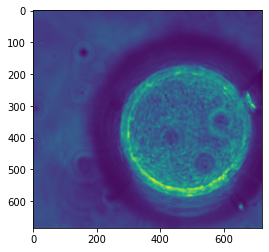

In [158]:
img = io.imread(l.Dir[500])
plt.imshow(img)

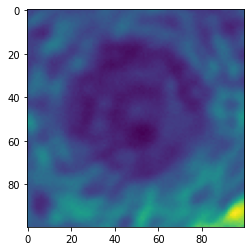

In [166]:
crop_anchor = np.array([435, 490])
crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
       crop_anchor[1], crop_anchor[1]+crop_size[1])
# need to check if the crop exceeds the borders of images
cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped)

In [169]:
# Initial params
crop_anchor = np.array([435, 490]) # upper left corner coords, int
crop_size = (100, 100) # height and width, int
save_crop_step = 20 # save cropped image every save_crop_step steps, int
main_output_folder = os.path.join(folder, 'crop_HoughCircles')
cropped_folder = os.path.join(folder, 'crop_HoughCircles', 'cropped_500-740')

# HoughCircles params
Hough_dp = 1
Hough_minDist = max(crop_size)
Hough_param2 = 1
Hough_maxRadius = 40
Hough_minRadius = 25

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
t_list = [] # frame number
nc_list = [] # number of circles detected in each frame

# initialize output folder

if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)
    
for num, i in l1.iterrows():
    img_raw = io.imread(i.Dir)
    # convert 16-bit to 8-bit
    if img_raw.dtype == 'uint16':
        img = (img_raw/2**8).astype('uint8')
    else:
        print(img_raw.dtype)
        break
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
    #     print(t, crop_anchor)
    
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None:
        x, y = circles[0, 0, 0]+crop_anchor[1], circles[0, 0, 1]+crop_anchor[0]
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
    else:
        x, y = np.nan, np.nan
    
    if num % save_crop_step == 0:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(cropped, cmap='gray')
        circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), 30,
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        plt.tight_layout()
        fig.savefig(os.path.join(cropped_folder, 'step_{:04d}.jpg'.format(num)))
        plt.close() # prevent figure from showing up inline
        
    t_list.append(num)
    x_list.append(x)
    y_list.append(y)
    nc_list.append(len(circles))
    if num > 600:
        break

# data = pd.DataFrame({'x':x_list, 'y':y_list, 't':t_list, 'num_circle':nc_list})
# data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)

**Comments:**
- Restart at frame 500, the software still loses the droplet very quickly. Therefore, the cropping problem may not be the primary issue.
- Other possible postprocessing may exist, so I leave this section for future development.

### 4.2 Trajectory validation
Generate overlays of trajectories and raw images. Find out false trackings and fix manually.

In [211]:
folder = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h42m46s'
mpp = 0.11 # microns per pixel
interval = 10 # plot skip
traj_length = 150 # only display the most recent trajectories, avoid overlapping

save_folder = os.path.join(folder, 'images', 'crop_HoughCircles', '2d-traj-animation')
image_folder = os.path.join(folder, 'images')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)

xyPosition = pd.read_csv(os.path.join(folder, 'images', 'crop_HoughCircles', 'traj.csv')).set_index('filename')

for i in range(len(xyPosition)):
    if i % interval != 0:
        continue
    print('{0:d}/{1:d}, {2:.2f}%'.format(i, len(xyPosition), i/len(xyPosition)*100))
    clear_output(wait=True)
    xyPosition1 = xyPosition[max(0, i-traj_length+1):i+1]
    zeros = np.zeros(len(xyPosition1))
    fig = plt.figure(figsize=(3, 3), dpi=100)
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(image_folder, '{:08d}.tif'.format(xyPosition1.index[-1])))
    ax.imshow(img, cmap='gray')
    ax.plot(xyPosition1.x, xyPosition1.y, ls=':', color='red')
    ax.axis('off')
    fig.savefig(os.path.join(save_folder, '{:08d}.jpg'.format(xyPosition1.index[-1])))
    plt.close()